# Analisi introduttive #
In questo notebook verranno presentate una serie di analisi in cui, tramite l'applicazione di random forest per ottenere la normalizzazione dei dati relativamente alle condizioni meteorologiche (come descritto nel notebook RandomForest.ipynb), si andrà a delinare il quadro della situazione per quanto riguarda gli inquinanti atmosferici in Lombardia mostrando anche come questa tecnica funzioni e quali risultati si ottengano dal suo utilizzo.

Verranno quindi analizzate le serie storiche normalizzate dei principali inquinanti atmosferici, usando i dati registrati nei dodici capoluoghi di provincia lombardi. Per ogni inquinante di ogni capoluogo dovrà essere creato un modello apposito, così da poter analizzare ogni situazione con un modello specifico creato appositamente per cercare di stimare al meglio le dinamiche locali degli eventi climatici e la loro relazione con gli inquinanti considerati. Chiaramente quindi per poter applicare la tecnica oltre alle registrazioni delle concentrazioni dell'inquinante sarà necessario recuperare anche i dati delle rilevazioni per le variabili meteorologiche che coinvolgeremo nel nostro processo.

In un file CSV che ho creato precedentemente sono andato a riassumere, in forma tabellare, gli ID dei sensori da usare per ottenere le serie storiche per le variabili di ciascun capoluogo. Questa tabella ci sarà utile per generare le serie normalizzate in modo programmatico, attraverso una funzione che per ogni inquinante di ogni città crei un modello apposito recuperando i dati grezzi dai file dei sensori specificati.

In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import data_preparation as data_prep
from AirNormalizer import AirNormalizer
import matplotlib.pyplot as plt
import glob
import os
import info_stazioni as info
plt.rcParams['figure.figsize'] = [10, 7]

id_sensori = pd.read_csv("sensori_capoluoghi.csv")
inquinanti = ["NO2", "NOX", "PM10", "O3", "CO", "SO2", "PM2.5", "Benzene", "Ammoniaca"]

def get_mean_inquinante(inquinante):
    files = glob.glob(f"../data/tmp/prepared_data_capoluoghi/*{inquinante}.csv")
    dfs = []
    for file in files:
        data = pd.read_csv(file, parse_dates=["Data"], index_col="Data")
        dfs.append(data)
    return pd.concat(dfs).groupby("Data").mean()

def get_mean_inquinante_normalizzato(inquinante):
    files = glob.glob(f"../data/tmp/prepared_data_capoluoghi/*{inquinante}_normalizzato.csv")
    dfs = []
    for file in files:
        data = pd.read_csv(file, parse_dates=["Data"], index_col="Data")
        dfs.append(data)
    return pd.concat(dfs).groupby("Data").mean()

id_sensori

,Citta,NO2,NOX,PM10,O3,CO,SO2,PM2.5,Benzene,Ammoniaca,Temperatura,Precipitazioni,Direzione_vento,Velocita_vento,Umidita,Radiazione
0,Milano,10279,10278,10273,10282,5834,10280,10283,17126,20020,2001,2006,14390,14391,2002,2008
1,Bergamo,5587,6220,6931,17297,5794,5670,10399,5989,-1,5864,5857,19105,19104,6158,6431
2,Crema,5958,6419,10339,5960,6418,5959,-1,-1,-1,5969,9329,19154,19153,6421,6440
3,Lecco,5577,6248,6927,10288,5805,6587,12029,10301,-1,10377,10376,19117,19116,10381,10382
4,Pavia,6685,6690,6947,6691,6705,6686,20157,6869,20156,6698,6694,17504,17502,6699,6696
5,Mantova,6871,9917,6955,20041,6879,6872,10347,6870,-1,9812,9816,9815,9821,9820,9818
6,Sondrio,5572,6382,6958,10437,5845,5704,10438,10259,-1,2096,2103,11829,11643,2097,2098
7,Brescia,6761,6766,6951,30165,6764,6966,9984,30166,-1,6795,6792,19077,19076,2415,4045
8,Varese,5555,6402,6918,5750,5853,5658,10449,-1,-1,8229,8228,14030,9073,6194,6476
9,Como,5564,6232,6919,6582,5798,5676,12570,29041,-1,9310,9308,19066,19065,9311,4012


Visto che la generazione di tutti i modelli e il calcolo delle serie normalizzate è un processo molto dispendioso dal punto di vista computazionale che richiede diverse ore, ho preparato uno script (build.py, **vedi README**) che estrae da un archivio compresso alcuni file CSV precedentemente generati e utili per poter eseguire tutto il notebook senza metterci troppo tempo. La funzione riportata sotto è stata quella utilizzata per generare i modelli ed i file che saranno usati poi nelle analisi seguenti.  
Dopo aver fatto girare lo script può essere poi eseguito il codice di tutte le celle di questo notebook (tranne chiaramente quello della cella seguente) senza avere attese troppo lunghe.

Rispetto a quanto fatto in precedenza, a partire da queste analisi il metodo di preparazione dei dati su cui si va a creare il modello è stato leggermente modificato. Prima, infatti, venivano considerate tutte le date per cui risultava disponibile la rilevazione dell'inquinante e se mancavano i valori delle altre variabili questi venivano riempiti con la media calcolata su tutte le osservazioni. Così facendo, però, se uno dei sensori relativo a queste variabili era stato messo in funzione tempo dopo rispetto a quello dell'inquinante le rilevazioni di tutte le date antecedenti venivano riempite col valore medio. Questo portava quindi ad avere dei dati meno "realistici" ed anche i modelli ottenuti risultavano meno precisi. Ora invece si considerano solo le osservazioni successive alla data di messa in funzione del sensore più recente tra tutti quelli coinvolti, andando a riempire con i valori medi solo eventuali buchi isolati. Questo ci permette sicuramente di ottenere quindi dei modelli più precisi, ma al prezzo di dover ridurre il periodo delle nostre anlisi in base alla disponibilità dei dati dei sensori.

In [3]:
#WARNING: CI METTE UN SACCO (> 10h)
#salvo i file cosi le prossime volte mi evito di dover rigenerare tutti i dati..
def norm_forall_capoluoghi():
    path = "../data/tmp/prepared_data_capoluoghi/"
    for inquinante in inquinanti:
        print(f"*** Inizio lavorazione {inquinante} ***")
        for index, row in id_sensori.iterrows():
            if(row[inquinante] != -1):
                try:
                    idsensore = row[inquinante]
                    data = data_prep.prepare_data(idsensore, row.Temperatura, row.Precipitazioni, row.Direzione_vento, row.Velocita_vento, row.Umidita, row.Radiazione)
                    data.to_csv(path + row.Citta + "_" + str(idsensore) + "_" + inquinante + ".csv")
                    normalizer = AirNormalizer(data)
                    print(f"-{row.Citta}: {normalizer.evaluate_testing()}")
                    norm_ts = normalizer.normalize_timeseries(n_preds=1000)
                    norm_ts.to_csv(path + row.Citta + "_" + str(idsensore) + "_" + inquinante + "_normalizzato.csv")
                except:
                    print(f"Exception occurred for {row.Citta} {inquinante}")
                    
#norm_forall_capoluoghi()

#NON NECESSARIA SE SI USA LO SCRIPT BUILD.PY

*** Inizio lavorazione NO2 ***
-Lodi: MSE     60.601341
RMSE     7.784686
R2       0.699858
dtype: float64
*** Inizio lavorazione NOX ***
-Lodi: MSE     580.124023
RMSE     24.085764
R2        0.704765
dtype: float64
*** Inizio lavorazione PM10 ***
-Lodi: MSE     197.481260
RMSE     14.052803
R2        0.629291
dtype: float64
*** Inizio lavorazione O3 ***
-Lodi: MSE     91.799222
RMSE     9.581191
R2       0.904360
dtype: float64
*** Inizio lavorazione CO ***
-Lodi: MSE     0.021683
RMSE    0.147252
R2      0.821806
dtype: float64
*** Inizio lavorazione SO2 ***
-Lodi: MSE     0.944697
RMSE    0.971955
R2      0.780980
dtype: float64
*** Inizio lavorazione PM2.5 ***
-Lodi: MSE     90.816377
RMSE     9.529763
R2       0.666379
dtype: float64
*** Inizio lavorazione Benzene ***
-Lodi: MSE     0.186598
RMSE    0.431969
R2      0.903814
dtype: float64
*** Inizio lavorazione Ammoniaca ***


I modelli ottenuti hanno tutti prestazioni molto buone, specialmente quelli relativi all'ozono, con le polveri sottili che rimangono sempre quelle a cui i nostri modelli fanno più fatica ad adattarsi, evidenziando ancora una volta come per questo tipo di inquinanti le sole variabili meteorologiche e temporali considerate non siano sufficienti per spiegarne completamente l'andamento.   

Voglio andare ora a controllare l'importanza delle variabili per ciascun modello creato, così da capire quali risultano maggiormente utili e se tra i diversi inquinanti entrano in gioco delle differenze.  
Da quando è stato modificato il processo di preparazione dei dati pre-normalizzazione è stata risolta la questione relativa alla scarsa importanza che veniva data a praticamente tutte le variabili meteorologiche in favore di quelle temporali, che probabilmente era causata dall'uso troppo elevato di valori medi. La funzione succesiva ci serve quindi per generare una tabella riassuntiva delle importanza delle variabili per i diversi inquinanti.

In [2]:
def feature_importance_summary_forall():    
    path = "../data/tmp/prepared_data_capoluoghi/"
    file_normalizzati = glob.glob(path + "*_normalizzato.csv")
    all_files = glob.glob(path + "*.csv")
    #recupero le tabelle pre-normalizzazione
    prepared_data = [x for x in all_files if x not in file_normalizzati]
    
    all_importances = pd.DataFrame(columns=inquinanti)
    
    for inquinante in inquinanti:
        print(f"Lavorazione {inquinante}")
        dfs = []
        files = [x for x in prepared_data if inquinante in x]
        for file in files:
            data = pd.read_csv(file, parse_dates=["Data"], index_col="Data")
            normalizer = AirNormalizer(data)
            dfs.append(normalizer.feature_importance())
        tot = pd.concat(dfs)
        tot = tot.groupby(tot.cols).mean().sort_values("imp", ascending=False)
        all_importances[inquinante] = tot.imp
        
    return all_importances
        
importances = feature_importance_summary_forall()
importances

Lavorazione NO2
Lavorazione NOX
Lavorazione PM10
Lavorazione O3
Lavorazione CO
Lavorazione SO2
Lavorazione PM2.5
Lavorazione Benzene
Lavorazione Ammoniaca


,NO2,NOX,PM10,O3,CO,SO2,PM2.5,Benzene,Ammoniaca
cols,,,,,,,,,
temperatura,0.281804,0.296089,0.183533,0.321900,0.263997,0.112839,0.236946,0.269504,0.116813
day_of_year,0.160389,0.190752,0.154019,0.125781,0.184588,0.143045,0.151051,0.168472,0.146152
velocita_vento,0.143894,0.158543,0.206909,0.068707,0.121522,0.065865,0.202892,0.153684,0.056647
epoch,0.131990,0.075234,0.080559,0.027216,0.177411,0.416001,0.074392,0.162360,0.352432
radiazione,0.081293,0.099686,0.073524,0.331668,0.099298,0.060573,0.082099,0.076012,0.073356
direzione_vento,0.056962,0.046213,0.054580,0.015457,0.040453,0.050973,0.051335,0.039195,0.066441
giorni_senza_pioggia,0.043695,0.033641,0.096110,0.011378,0.027543,0.050533,0.070959,0.024561,0.048331
umidita,0.039273,0.051606,0.087195,0.082447,0.050990,0.056521,0.081110,0.068633,0.089723
day_of_week,0.039100,0.029176,0.021514,0.007527,0.015023,0.019295,0.019215,0.018799,0.026682


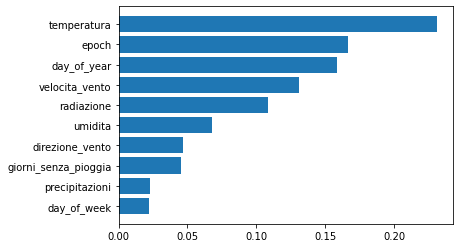

In [4]:
medie_imp = importances.mean(axis=1).sort_values()
plt.barh(medie_imp.index, medie_imp.values)
plt.show()

Come si può vedere la variabile più importante è la temperatura, seguita dalla data e dal giorno dell'anno. Questa considerazione però non dovrebbe meravigliarci se pensiamo al collegamento che esiste tra ciascuna e l'inquinamento: la temperatura serve sia ad identificare i cicli stagionali che eventuali periodi più caldi o freddi della media in cui la gente potrebbe inquinare maggiormente in risposta a questi eventi, la data ci permette di identificare l'evoluzione nel corso degli anni dei valori registrati, e quindi la presenza di eventuali trend o andamenti particolari, e il giorno dell'anno serve per identificare la stagionalità caratteristica degli inquinanti.

Ancora una volta, invece, sembra che alle due variabili legate alle precipitazioni venga data una scarsa importanza. È bene ricordare, però, che l'importanza delle variabili è calcolata come il totale della diminuzione dell'impurità dei nodi della foresta, pesata per la probabilità di raggiungere ciascun nodo ([Vedi capitolo 10 per spiegazione più dettagliata](https://link.springer.com/article/10.1023/A:1010933404324)). Questa è quindi una misura che cerca di stimare come lavori il nostro modello per fare previsioni, ma non indica assoultamente che tipo di relazioni ci siano tra la variabile considerata e quella da predirre. Quindi, anche se nel nostro modello alle precipitazioni viene associata una bassa importanza, non ci sta dicendo che non abbiano influenza sulle concentrazioni registrate, ma semplicemente che la variabile per lui è meno utile per fare previsioni più precise. 

## NOx e NO2 ##
Nella categoria degli ossidi di azoto sono considerati due inquinanti di diverso interesse e che quindi è bene analizzare separatamente. Il monossido di azoto, infatti, alle concentrazioni tipiche misurate non risulta pericoloso nè per la salute umana nè per la vegetazione; il biossido di azoto, invece, desta sicuramente una maggior preoccupazione per i suoi effetti sulla salute. Per questo motivo considererò ed analizzerò separatamente le serie dei sensori misuratori di NOx e di quelli dedicati solo al biossido.

Inizialmente vorrei quindi andare ad analizzare le serie degli ossidi di azoto.
Quando si considerano questi inquinanti è bene ricordare che il monossido ha principalmente origine primaria, mentre il biossido si genera in atmosfera grazie all'ossidazione del primo e quindi ha origine principalmente secondaria. All'emissione, infatti, si stima che il biossido sia circa il 5/10% del totale per questa categoria ([Rapporto sulla qualità dell'aria di Milano 2018 - ARPA Lombardia](https://www.arpalombardia.it/qariafiles/RelazioniAnnuali/RQA_MI_2018.pdf)). Entrambi sono emessi in atmosfera da processi di combustione ad alta temperatura (impianti di riscaldamento, motori dei veicoli, combustioni industriali, centrali di potenza, ecc..) e per ossidazione dell'azoto presente in atmosfera (o dei suoi composti contenuti nei combustibili utilizzati).
Il biossido di azoto, oltre che alla pericolosità per quanto riguarda la salute di persone e vegetazione, ha un ruolo fondamentale nella formazione dello smog fotochimico in quanto è l'intermediario per la produzione di inquinanti secondari come l'ozono.

Secondo l'inventario regionale [INEMAR 2017](http://www.inemar.eu/xwiki/bin/view/InemarDatiWeb/Inventario+delle+emissioni+in+atmosfera) la categoria maggiormente responsabile per le emissioni di questi inquinanti è il trasporto su strada, con un contributo pari al 50% del totale delle emissioni, seguita dalle combustioni industriali e civili (con circa il 15% di contributo ciascuna). Sempre secondo l'inventario il combustibile maggiormente responsabile delle emissioni di questa categoria è il diesel, con oltre il 50% del totale delle emissioni, seguito dal gas naturale (20%).

Le prime normative introdotte per contenerne le concentrazioni sono arrivate nei primi anni 90, imponendo limiti alle emissioni degli impianti e favorendo l'uso del gas naturale al posto di gasolio e cherosene come combustibili. Negli anni più recenti i limiti normativi sono stati ulteriormente abbassati.
Per quanto riguarda il traffico, visto che è il settore maggiormente responsabile, i provvedimenti più importanti sono sicuramente l'introduzione delle marmitte catalitiche e l'introduzione di limiti alle emissioni dei veicoli, con le famose categorie EuroX. Proprio questo ultimo aspetto ha fatto sì che, sebbene nel corso degli anni il numero dei veicoli circolanti e dei kilometri percorsi sia aumentato, l'inquinante abbia comunque fatto registrare un trend in forte calo nel corso degli anni.
(Analisi più dettagliate per quanto riguarda il traffico e le sue normative saranno fatte separatamente).

Prima di andare a controllare l'andamento della media delle serie normalizzate dei 12 capoluoghi di provincia lombardi credo sia utile controllare l'importanza media delle variabili nei modelli generati per applicare la normalizzazione. Il codice seguente estrae dalla tabella generata in precedenza la colonna di interesse.

In [74]:
importances["NOX"].sort_values(ascending=False)

cols
temperatura             0.296089
day_of_year             0.190752
velocita_vento          0.158543
radiazione              0.099686
epoch                   0.075234
umidita                 0.051606
direzione_vento         0.046213
giorni_senza_pioggia    0.033641
day_of_week             0.029176
precipitazioni          0.019060
Name: NOX, dtype: float64

Le variabili più importanti sono la temperatura, che risulta quella col valore decisamente maggiore rispetto alle altre, il giorno dell'anno e la velocità del vento. Sicuramente non siamo sorpresi dalle prime due, visto il classico andamento stagionale dell'inquinante, legato sia alle maggiori emissioni antropiche durante il periodo invernale che alle condizioni più sfavorevoli alla dispersione. Anche la velocità del vento non ci stupisce, vista appunto la forte azione dispersiva svolta da questo elemento.

Andiamo ora a controllare gli andamenti delle serie, generando i grafici sia delle medie mensili che delle medie annuali. 
I pezzi di codice seguenti si occupano di farlo, recuperando i dati dai file provvisori generati in precedenza **e scompattati dallo script di build** (vedi README per dettagli su come eseguire il seguente codice).

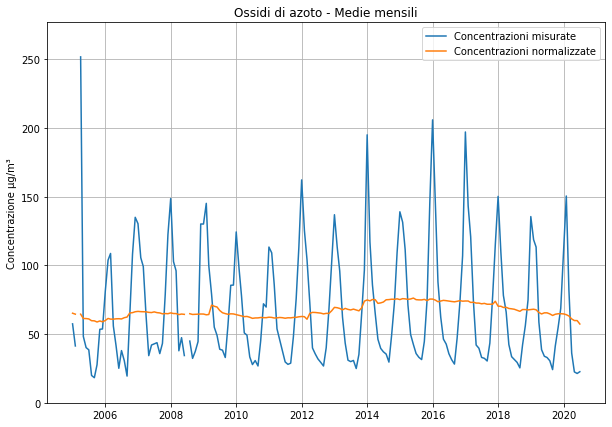

In [6]:
medie = get_mean_inquinante("NOX")
medie_norm = get_mean_inquinante_normalizzato("NOX")
medie = medie.groupby(pd.Grouper(freq="M")).mean()
medie_norm = medie_norm.groupby(pd.Grouper(freq="M")).mean()
max_y = max(medie.inquinante) if max(medie.inquinante) >= max(medie_norm.inquinante) else max(medie_norm.inquinante)
plt.plot(medie.index, medie.inquinante, label="Concentrazioni misurate")
plt.plot(medie_norm.index, medie_norm.inquinante, label="Concentrazioni normalizzate")
plt.ylabel("Concentrazione µg/m³")
plt.title("Ossidi di azoto - Medie mensili")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y/10))
plt.show()

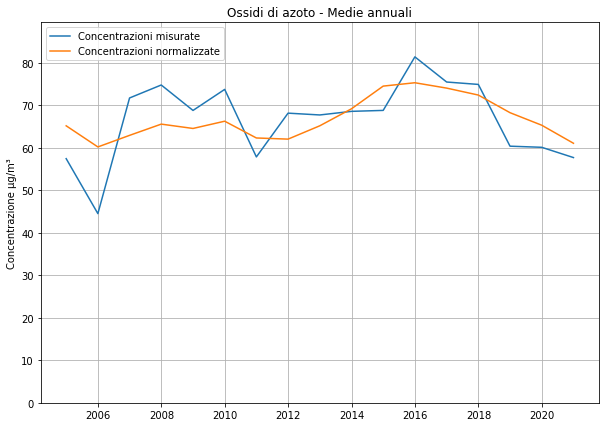

In [7]:
medie = get_mean_inquinante("NOX")
medie_norm = get_mean_inquinante_normalizzato("NOX")
medie = medie.groupby(pd.Grouper(freq="y")).mean()
medie_norm = medie_norm.groupby(pd.Grouper(freq="y")).mean()
max_y = max(medie.inquinante) if max(medie.inquinante) >= max(medie_norm.inquinante) else max(medie_norm.inquinante)
plt.plot(medie.index, medie.inquinante, label="Concentrazioni misurate")
plt.plot(medie_norm.index, medie_norm.inquinante, label="Concentrazioni normalizzate")
plt.ylabel("Concentrazione µg/m³")
plt.title("Ossidi di azoto - Medie annuali")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y/10))
plt.show()

Innanzitutto controllando il grafico delle medie mensili si nota come la serie normalizzata riesca a non essere influenzata dall'andamento stagionale, mantenendo sempre un livello "medio" costante, che è proprio il risultato che ci aspettavamo di ottenere dall'applicazione della nostra tecnica. Noi volevamo riuscire ad avere delle serie che fossero indipendenti da tutti questi fattori che possono incidere sulle concentrazioni e visto l'andamento mostrato da quella ottenuta, che rimane approssimativamente intorno ad un valore "medio" indipendentemente dalla giornata, possiamo essere abbastanza fiduciosi di essere riusciti a stimarla con una buona precisione.  
Sulle medie annuali vengono sicuramente eliminati i picchi, probabilmente causati da condizioni meteorologiche più favorevoli/sfavorevoli all'accumulo avute da alcuni anni in particolare (ad esempio 2006 o 2011), ma l'andamento delle due serie risulta comunque compatibile, ancora una volta a dimostrazione della validità del risultato ottenuto, che sarebbe sicuramente stata messa in discussione se si fossero ottenuti dei risultati completamente diversi. 

Guardando i grafici si vede chiaramente che l'andamento delle concentrazioni misurate dal 2006 ad oggi sia abbastanza costante, con un aumento abbastanza significativo registrato tra gli anni 2012 e 2016, seguito però poi da un costante calo che ormai le ha riportate ai livelli di 8 anni fa. Se avessimo avuto a disposizione le serie complete a partire dai primi anni 90 sicuramente avremmo visto un trend negativo nelle concentrazioni, poichè è stato proprio in quel decennio che le emissioni sono state maggiormente ridotte. Negli ultimi anni non sono state introdotte nuove importanti normative a riguardo, se non aggiornamenti dei limiti imposte da quelle già esistenti (sia per quanto riguarda le emissioni degli impianti che dei veicoli). Questo sicuramente ha aiutato a mantenere le concentrazioni su un livello abbastanza costante, nonostante il numero di veicoli circolanti sia in continuo aumento.

Andiamo ora ad occuparci del biossido di azoto misurato singolarmente. Per le concentrazioni di questo inquinante il D.Lgs 155/2010 ha stabilito le seguenti soglie: 200µg/m³ sulla media oraria, con un massimo di 18 superamenti annui concessi, e di 40µg/m³ per la media annua. Se il limite sull'ora non viene praticamente mai superato, quello della media annua non sempre viene rispettato. Nel rapporto di ARPA Lombardia [Rapporto sulla qualità dell'aria di Milano 2018 - ARPA Lombardia](https://www.arpalombardia.it/qariafiles/RelazioniAnnuali/RQA_MI_2018.pdf) per quanto riguarda la provincia milanese, nel 2018, 7 stazioni su 14 hanno fatto registrare una media annuale superiore al limite imposto.

È chiaro quindi che questo sia un inquinante di interesse, soprattutto per quando si vuole analizzare l'impatto del traffico sulla qualità dell'aria, essendone così fortemente responsabile.

Andiamo a controllare l'importanza delle variabili anche di questo inquinante, anche se ci aspettiamo di ottenere un risultato simile a quanto visto in precedenza.

In [14]:
importances["NO2"].sort_values(ascending=False)

cols
temperatura             0.281804
day_of_year             0.160389
velocita_vento          0.143894
epoch                   0.131990
radiazione              0.081293
direzione_vento         0.056962
giorni_senza_pioggia    0.043695
umidita                 0.039273
day_of_week             0.039100
precipitazioni          0.021601
Name: NO2, dtype: float64

Vengono infatti confermate le tre variabili più importanti già ottenute in precedenza, con valori anche abbastanza simili.

Andiamo ora a controllare l'andamento delle serie normalizzate ottenute.

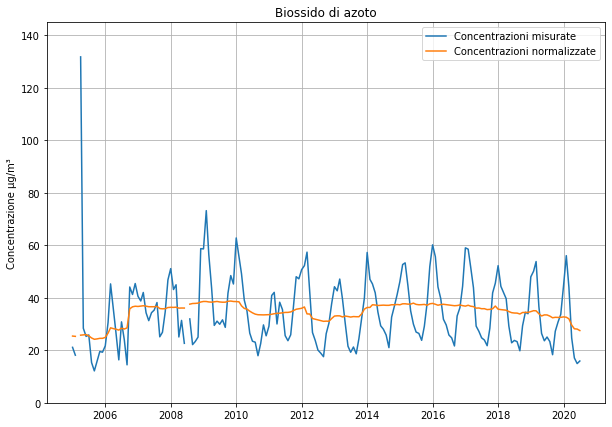

In [13]:
medie = get_mean_inquinante("NO2")
medie_norm = get_mean_inquinante_normalizzato("NO2")
medie = medie.groupby(pd.Grouper(freq="M")).mean()
medie_norm = medie_norm.groupby(pd.Grouper(freq="M")).mean()
max_y = max(medie.inquinante) if max(medie.inquinante) >= max(medie_norm.inquinante) else max(medie_norm.inquinante)
plt.plot(medie.index, medie.inquinante, label="Concentrazioni misurate")
plt.plot(medie_norm.index, medie_norm.inquinante, label="Concentrazioni normalizzate")
plt.ylabel("Concentrazione µg/m³")
plt.title("Biossido di azoto")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y/10))
plt.show()

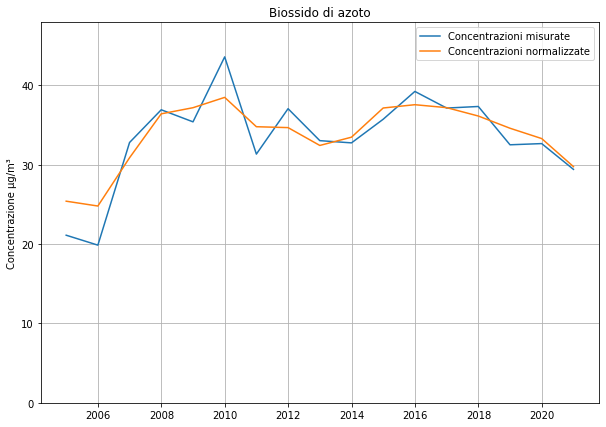

In [9]:
medie = get_mean_inquinante("NO2")
medie_norm = get_mean_inquinante_normalizzato("NO2")
medie = medie.groupby(pd.Grouper(freq="y")).mean()
medie_norm = medie_norm.groupby(pd.Grouper(freq="y")).mean()
max_y = max(medie.inquinante) if max(medie.inquinante) >= max(medie_norm.inquinante) else max(medie_norm.inquinante)
plt.plot(medie.index, medie.inquinante, label="Concentrazioni misurate")
plt.plot(medie_norm.index, medie_norm.inquinante, label="Concentrazioni normalizzate")
plt.ylabel("Concentrazione µg/m³")
plt.title("Biossido di azoto")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y/10))
plt.show()

Anche per il biossido considerato separatamente le serie ottenute presentano un andamento abbastanza costante e anche in questo caso sembra che dal 2016 le concentrazioni siano leggermente in calo, anche se già in passato (2010-2013) si erano verificati andamenti simili, salvo poi essere tornate ad aumentare negli anni successivi.  
Sicuramente credo sia importante notare che le medie annuali delle serie normalizzate rimangano sempre sotto alla soglia imposta dalla normativa vigente, a segno che comunque la situazione per quanto riguarda questo inquinante non sia proprio così critica come viene invece descritta a volte. Chiaramente questo non significa che non sia importante monitorarla ed occuparsene, visto che comunque in casi di particolari condizioni atmosferiche può capitare che si abbiano delle situazioni leggermente problematiche, ma di certo le concentrazioni di questo inquinante non possono essere considerate un problema grave attualmente.  
C'è inoltre da dire che nel corso dei prossimi anni questo inquinante potrebbe ulteriormente calare, poichè l'innovazione tecnologica, soprattutto per quanto riguarda il mondo delle [auto](https://www.bosch-press.it/pressportal/it/it/press-release-22465.html) e il rinnovo della flotta circolante porteranno ad avere ulteriori abbassamenti delle emissioni. Chiaramente ci si può aspettare di vedere un processo simile anche per quanto riguarda le combustioni industriali e civili, che sono gli altri due settori importanti per quanto riguarda questo inquinante.

## PM10 e PM2.5 ##  
Le polveri sottili sono sicuramente l'inquinante più discusso degli ultimi anni essendo quello le cui concentrazioni fanno registrare il maggior numero di superamenti della soglia imposta per legge e del quale è noto l'elevato impatto ambientale e sulla salute degli esseri viventi. Questo fa sì che si accendano spesso dibattiti sulla qualità reale dell'aria che respiriamo e su quali misure siano necessarie per riuscire a mantenere le concentrazioni sotto al valore limite oltre il quale il [WHO](https://www.who.int/news-room/fact-sheets/detail/ambient-(outdoor)-air-quality-and-health) ha riconosciuto la possibilità di avere danni alla salute. Prima di andare ad analizzare i dati è però bene aver chiaro il contesto in cui si svolgeranno queste analisi. Il particolato è sicuramente un inquinante molto legato alla stagionalità, sia perchè le condizioni meteorologiche invernali sono più favorevoli all'accumulo rispetto a quelle estive che per le maggior emissioni antropiche tipiche della stagione, causate, ad esempio, dall'uso dei riscaldamenti. Va inoltre ricordato che la Lombardia, come tutto il bacino padano in generale, si trova in una posizione geografica sfavorevole, che porta alla maggior formazione di accumuli, soprattutto durante il periodo invernale. 

Il particolato classicamente viene diviso in due categorie: PM10 e PM2.5, a seconda del diametro aerodinamico delle particelle esaminate. Quindi particelle con questo diametro, che non si riferisce alla dimensione della particella ma alla sue caratteristiche aerodinamiche, al di sotto dei 10µm sono classificate come PM10 e il discorso analogo vale anche per il PM2.5.
Essendo appunto particelle molto piccole risultano quindi pericolose per la salute poichè riescono a penetrare più a fondo nell'apparato respiratorio, arrivando quindi ad arrecare danni maggiori. La pericolosità del particolato non deriva solamente dalla sua composizione, che è molto varia per le diverse origini che può avere, ma anche dal fatto che fa da veicolante per altri inquinanti più pericolosi, che si legano in atmosfera e vengono poi trasportate all'interno del corpo dalla particella. 
Questo inquinante ha appunto origini molto varie, sia di tipo primario da attività come le industrie, i riscaldamenti, il traffico e le combustioni in generale, ma anche di tipo secondario, poichè in atmosfera può formarsi a seguito di trasformazioni chimico-fisiche di altre sostanze.

Secondo INEMAR 2017 la categoria maggiormente responsabile per le emissioni di questi inquinanti sono le combustioni non industriali, quindi, ad esempio, i riscaldamenti domestici, specialmente quelli a biomasse. Il contributo di questa categoria si aggira intorno al 45% per quanto riguarda il PM10 ed al 50% per il PM2.5.
Al secondo posto troviamo il traffico, con un contributo che arriva al 25% per quanto riguarda la frazione più grossa del particolato e del 20% per la più piccola.
Per quanto riguarda i combustibili, il legno è di gran lunga il maggior responsabile delle emissioni di particolato, con oltre il 50% del totale. Il diesel, che spesso viene adirittura accusato di essere il maggior responsabile di questo tipo di emissioni, si ferma invece a solo circa il 10%.

Il PM10 è regolato dall'inizio degli anni 90, con i decreti già citati per  gli ossidi di azoto che hanno introdotto limiti e nuove regolamentazioni per le emissioni degli impianti.Per quanto riguarda il settore del traffico l'introduzione più importante è stata quella del filtro antiparticolato nelle marmitte, che permette di ridurre drasticamente le emissioni, insieme chiaramente alle progressive limitazioni imposte tramite le categorie EuroX. Quando si parla di traffico e polveri sottili è importante ricordare che i motori a benzina non generano questo inquinante ed infatti le loro emissioni non sono normate nemmeno dalle sopracitate categorie internazionali.  

Per quanto riguarda il PM10 il D.Lgs 155/2010 impone questi limiti di legge: 50µg/m³ come media giornaliera, che non deve essere superata in più di 35 occasioni, e 40µg/m³ per la media annuale.
Un aspetto su cui potrebbe valer la pena indagare è il motivo per cui, per questo inquinante, il limite per la media giornaliera sia così vicino a quello per la media annuale, mentre per altri inquinanti questa differenza è molto più ampia.

Andiamo quindi ad analizzare le serie normalizzate di questa prima categoria, iniziando ancora con il controllo dell'importanza delle variabili nei modelli generati.

In [23]:
importances["PM10"].sort_values(ascending=False)

cols
velocita_vento          0.206909
temperatura             0.183533
day_of_year             0.154019
giorni_senza_pioggia    0.096110
umidita                 0.087195
epoch                   0.080559
radiazione              0.073524
direzione_vento         0.054580
precipitazioni          0.042057
day_of_week             0.021514
Name: PM10, dtype: float64

Per questa categoria la variabile più importante risulta essere, non sorprendentemente vista la sua azione dispersiva, la velocità del vento.
Al secondo posto troviamo la temperatura ed al terzo il giorno dell'anno, che sono collegate al classico andamento stagionale che fanno registrare le concentrazioni di questo inquinante.
Vediamo inoltre come al numero di giorni dalle ultime precipitazioni registrate venga data un'importanza abbastanza discreta; neanche questo dovrebbe sorprenderci però, infatti è noto come la pioggia abbatta le concentrazioni portando al suolo parte del particolato presente in atmosfera e la sua assenza prolungata, soprattutto in periodi come quello invernale dove la dispersione naturale è resa più difficile dalle condizioni climatiche, non può quindi che portare ad un innalzamento. Grazie all'importanza ottenuta possiamo quindi capire che i modelli costruiti sono riusciti in qualche modo a rilevare questo tipo di relazione e perciò sono anche in grado di poterne eliminare gli effetti più efficacemente.

Andiamo ora a generare i grafici delle medie mensili e annuali dei capoluoghi lombardi, per verificare cosa otteniamo dall'applicazione della nostra tecnica.

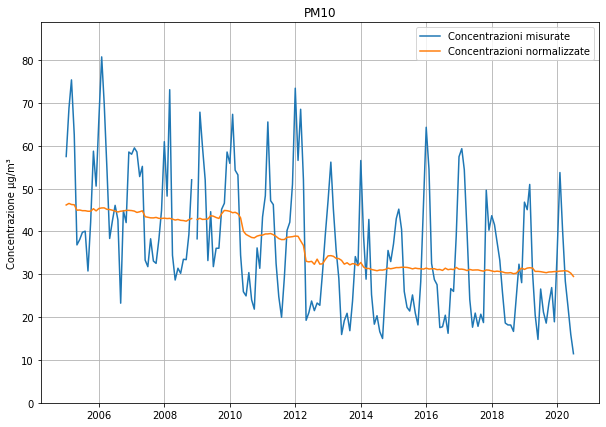

In [17]:
medie = get_mean_inquinante("PM10")
medie_norm = get_mean_inquinante_normalizzato("PM10")
medie = medie.groupby(pd.Grouper(freq="M")).mean()
medie_norm = medie_norm.groupby(pd.Grouper(freq="M")).mean()
max_y = max(medie.inquinante) if max(medie.inquinante) >= max(medie_norm.inquinante) else max(medie_norm.inquinante)
plt.plot(medie.index, medie.inquinante, label="Concentrazioni misurate")
plt.plot(medie_norm.index, medie_norm.inquinante, label="Concentrazioni normalizzate")
plt.ylabel("Concentrazione µg/m³")
plt.title("PM10")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y/10))
plt.show()

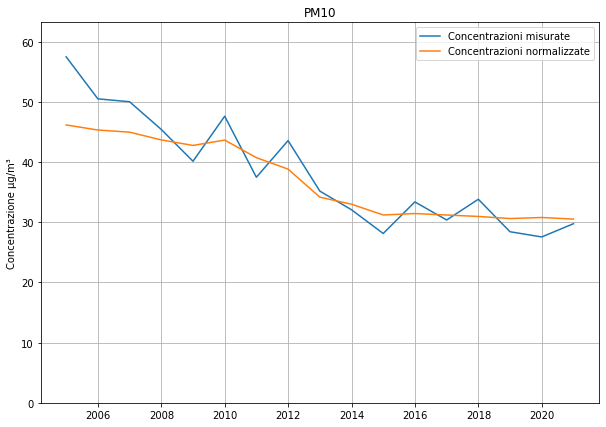

In [4]:
medie = get_mean_inquinante("PM10")
medie_norm = get_mean_inquinante_normalizzato("PM10")
medie = medie.groupby(pd.Grouper(freq="y")).mean()
medie_norm = medie_norm.groupby(pd.Grouper(freq="y")).mean()
max_y = max(medie.inquinante) if max(medie.inquinante) >= max(medie_norm.inquinante) else max(medie_norm.inquinante)
plt.plot(medie.index, medie.inquinante, label="Concentrazioni misurate")
plt.plot(medie_norm.index, medie_norm.inquinante, label="Concentrazioni normalizzate")
plt.ylabel("Concentrazione µg/m³")
plt.title("PM10")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y/10))
plt.show()

Nei grafici ottenuti è evidente la presenza di un trend in costante calo, anche se negli ultimi anni sembra aver rallentato molto ed i valori rimangono piuttosto costanti.  
Importante notare come successivamente al 2012 le concentrazioni normalizzate siano rimaste sempre sotto al limite per la media annuale di 40µg/m³, sia per quanto riguarda le medie annuali che per quelle mensili.  
Ancora una volta vediamo come le serie normalizzate ottenute mantengano un andamento medio rispetto ai dati grezzi, a conferma nuovamente della validità dei risultati ottenuti tramite questa tecnica.  
Guardando i grafici sembrerebbe quasi che nel corso degli ultimi anni si possa aver raggiunto una sorta di limite, dovuto dalla quantità di attività antropiche (e in parte probabilmente anche da un fondo naturale) presenti nella nostra regione, oltre il quale sarà più complicato scendere ulteriormente. 
Quello che invece risulta evidente è che, se non fosse per le condizioni sfavorevoli in cui si trova la Lombardia e che quindi nei periodi più critici portano ad avere episodi con concentrazioni più alte, la qualità dell'aria anche per quanto riguarda questo inquinante non è assolutamente così terribile come spesso invece si sente dire.

Andiamo ora ad analizzare anche i dati per il PM2.5, iniziando ancora dall'importanza delle variabili, per il quale ricordiamo che il limite di legge è fissato a 25µg/m³ sulla media annua, introdotto per la prima volta a partire dal D.Lgs 155/2010.

In [24]:
importances["PM2.5"].sort_values(ascending=False)

cols
temperatura             0.236946
velocita_vento          0.202892
day_of_year             0.151051
radiazione              0.082099
umidita                 0.081110
epoch                   0.074392
giorni_senza_pioggia    0.070959
direzione_vento         0.051335
precipitazioni          0.030002
day_of_week             0.019215
Name: PM2.5, dtype: float64

La situazione è ancora abbastanza simile a quella di prima, come potevamo immaginare vista la similitudine delle relazioni tra questi inquinanti e le variabili usate nei nostri modelli.

Generiamo quindi i grafici delle serie, per verificare i risultati ottenuti.

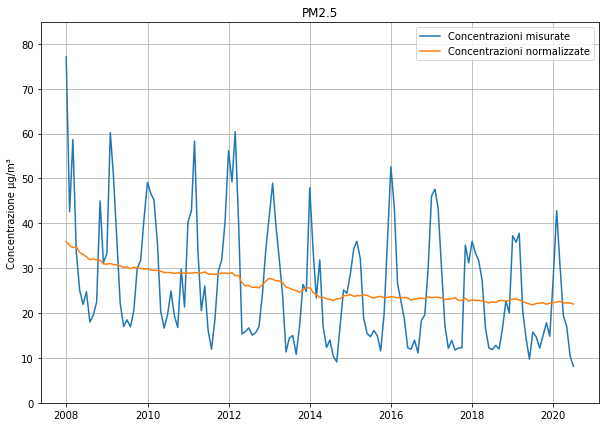

In [24]:
medie = get_mean_inquinante("PM2.5")
medie_norm = get_mean_inquinante_normalizzato("PM2.5")
medie = medie.groupby(pd.Grouper(freq="M")).mean()
medie_norm = medie_norm.groupby(pd.Grouper(freq="M")).mean()
max_y = max(medie.inquinante) if max(medie.inquinante) >= max(medie_norm.inquinante) else max(medie_norm.inquinante)
plt.plot(medie.index, medie.inquinante, label="Concentrazioni misurate")
plt.plot(medie_norm.index, medie_norm.inquinante, label="Concentrazioni normalizzate")
plt.ylabel("Concentrazione µg/m³")
plt.title("PM2.5")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y/10))
plt.show()

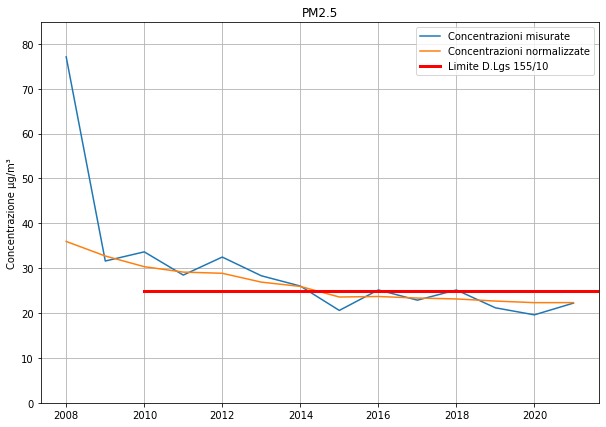

In [22]:
medie = get_mean_inquinante("PM2.5")
medie_norm = get_mean_inquinante_normalizzato("PM2.5")
medie = medie.groupby(pd.Grouper(freq="y")).mean()
medie_norm = medie_norm.groupby(pd.Grouper(freq="y")).mean()
max_y = max(medie.inquinante) if max(medie.inquinante) >= max(medie_norm.inquinante) else max(medie_norm.inquinante)
plt.plot(medie.index, medie.inquinante, label="Concentrazioni misurate")
plt.plot(medie_norm.index, medie_norm.inquinante, label="Concentrazioni normalizzate")
plt.axhline(25, xmin=.185, label="Limite D.Lgs 155/10", color="red", linewidth=3)
plt.ylabel("Concentrazione µg/m³")
plt.title("PM2.5")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y/10))
plt.show()

Anche per questa categoria viene evidenziato un trend negativo leggermente minore di quanto riscontrato col PM10 e che però negli ultimi anni presenta la stessa tendenza al rallentamento, che rinforza i nostri sospetti di aver raggiunto una sorta di limite.  
Notiamo come dal 2015 le concentrazioni normalizzate siano riuscite anche a scendere sotto al limite di legge imposto e come, anche in questo caso, siano fortemente influenzate dalle condizioni sfavorevoli che poi portano spesso ad avere episodi problematici.

## CO ##
Il monossido di carbonio è un inquinante molto pericoloso per la salute, in quanto è nota la sua migliore capacità di legarsi all'emoglobina rispetto all'ossigeno, causando notevoli danni per l'uomo.  
È un inquinante che viene prodotto da combustioni in difetto di ossigeno ed ha origine prevalentemente primaria, essendo emesso direttamente da tutti i processi di combustione incompleta dei composti carboniosi (gas naturali, propano, carburanti, benzine, carbone, legna, ecc..).

Secondo quanto riportato da INEMAR 2017 i due settori maggiormente responsabili delle emissioni di questo inquinante sono il traffico ed i riscaldamenti domestici e le combustioni non industriali, con un contributo pari rispettivamente al 38% e 27% del totale delle emissioni annue. Le emissioni collegate al settore dei trasporti hanno fatto registrare forti cali a partire dagli anni 90, con una riduzione vicina addirittura al 90% favorita da innovazioni quali le marmitte catalitiche e in generale il progresso tecnologico che, per esempio, ha permesso di passare dai 12,66gCO/km emessi dai motori a benzina classificati come Euro 0 (quelli antecedenti all'istituzione delle normative europee) a 1gCO/km che viene imposto come limite per la categoria Euro 6.  
Per quanto riguarda invece il settore dei riscaldamenti domestici nel corso degli ultimi anni le emissioni hanno seguito un trend sempre crescente, causato soprattutto dall'uso della legna come combustibile, che però porta effetti riscontrabili solo localmente dove è più utilizzata (e solitamente le aree cittadine non sono questo tipo di zone).

Il limite di legge alle concentrazioni di questa sostanza in atmosfera è fissato a 10 µg/m³ a partire dal 2005, anche se ormai sono più di vent'anni che non vengono registrati valori maggiori. Il monossido, quindi, ormai non rappresenta più un problema e le sue concentrazioni in atmosfera sono molto vicine al fondo naturale (come citato da ARPA nel rapporto sulla qualità dell'aria di Milano 2018) e spesso si arriva anche ai limiti della rilevabilità da parte dei sensori.  
Pur non essendo più un problema credo che valga comunque la pena analizzare la situazione anche per quanto riguarda questo inquinante, ripetendo quanto fatto in precedenza per gli altri.

In [25]:
importances["CO"].sort_values(ascending=False)

cols
temperatura             0.263997
day_of_year             0.184588
epoch                   0.177411
velocita_vento          0.121522
radiazione              0.099298
umidita                 0.050990
direzione_vento         0.040453
giorni_senza_pioggia    0.027543
precipitazioni          0.019175
day_of_week             0.015023
Name: CO, dtype: float64

Per quanto riguarda l'importanza delle variabili abbiamo una situazione abbastanza in linea con quanto ottenuto per gli altri inquinanti e anche con quello che ci aspettavamo di ottenere. La variabile più importante risulta essere la temperatura e, visto il collegamento tra questo inquinante e l'utilizzo dei riscaldamenti domestici, credo che questo non ci debba sorprendere. Come sempre viene data una buona importanza al giorno dell'anno, visto che anche questo inquinante rispetta un andamento ampiamente stagionale, oltre che alla data ed alla velocità del vento.

Passiamo ora alla generazione dei grafici delle medie delle serie normalizzate di questo inquinante calcolate per i capoluoghi della regione.

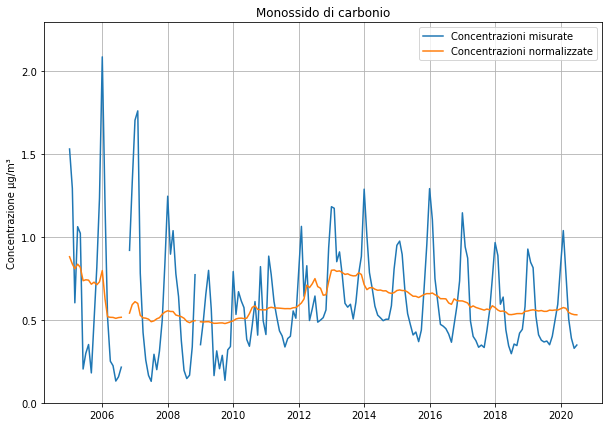

In [18]:
medie = get_mean_inquinante("CO")
medie_norm = get_mean_inquinante_normalizzato("CO")
medie = medie.groupby(pd.Grouper(freq="M")).mean()
medie_norm = medie_norm.groupby(pd.Grouper(freq="M")).mean()
max_y = max(medie.inquinante) if max(medie.inquinante) >= max(medie_norm.inquinante) else max(medie_norm.inquinante)
plt.plot(medie.index, medie.inquinante, label="Concentrazioni misurate")
plt.plot(medie_norm.index, medie_norm.inquinante, label="Concentrazioni normalizzate")
plt.ylabel("Concentrazione µg/m³")
plt.title("Monossido di carbonio")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y/10))
plt.show()

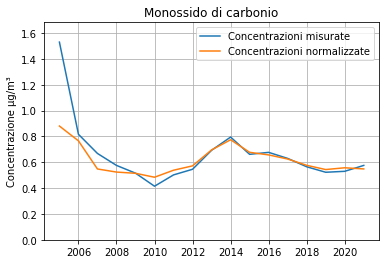

In [2]:
medie = get_mean_inquinante("CO")
medie_norm = get_mean_inquinante_normalizzato("CO")
medie = medie.groupby(pd.Grouper(freq="y")).mean()
medie_norm = medie_norm.groupby(pd.Grouper(freq="y")).mean()
max_y = max(medie.inquinante) if max(medie.inquinante) >= max(medie_norm.inquinante) else max(medie_norm.inquinante)
plt.plot(medie.index, medie.inquinante, label="Concentrazioni misurate")
plt.plot(medie_norm.index, medie_norm.inquinante, label="Concentrazioni normalizzate")
plt.ylabel("Concentrazione µg/m³")
plt.title("Monossido di carbonio")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y/10))
plt.show()

Dal 2006 ad oggi le concentrazioni di monossido di carbonio sono rimaste piuttosto stabili, mostrando un andamento abbastanza costante, con un leggero aumento tra il 2010 e il 2014, seguito poi però da una fase di leggero calo. Questo andamento, che risulta praticamente costante e caratterizzato da variazioni piuttosto casuali, può sicuramente farci pensare di essere vicini alla misura del fondo naturale anche per questo inquinante, che ormai da anni non rappresenta più un problema.  
Va infatti notato come nel periodo preso in esame i valori siano sempre rimasti sotto al 1 µg/m³, ben più bassi del limite imposto dalla legge. Inoltre le medie delle serie normalizzate seguono abbastanza bene quelle delle concentrazioni reali, facendoci quindi pensare che le fluttuazioni possano essere più oscillazioni nel valore del fondo naturale che cambiamenti dovuti ad attività umane o altri fattori come quelli considerati nel nostro modello.

## Ozono ##
L'ozono troposferico è un inquinante di origine secondaria, che si forma in atmosfera quando, favoriti da alte temperature e forte irraggiamento, ossidi di azoto e composti organici volatili subiscono trasformazioni chimico-fisiche che portano alla sua formazione. Per questo motivo l'ozono è considerato smog fotochimico ed il periodo critico per le sue concentrazioni, a differenza degli altri inquinanti, è quindi l'estate.  
I precursori dell'ozono arrivano generalmente da combustioni civili ed industriali e da processi che usano o producono sostanze chimiche volatili, ma avendo una formazione più complessa è chiaramente più difficile capire quali siano le sue origini e quindi dove intervenire per controllarne efficacemente le concentrazioni.  

L'ozono è noto per la sua pericolosità per l'apparato respiratorio, al quale può causare problemi temporanei anche a seguito di un'esposizione a basse concentrazioni; chiaramente se l'esposizione avviene in modo ripetuto o prolungato il rischio di avere dei danni permanenti aumenta. 
In generale comunque, soprattutto ad alte concentrazioni, l'ozono diventa pericoloso sia per gli esseri umani che per la vegetazione, sulla quale può avere effetti negativi.

La normativa attuale fissa a 120 µg/m³ il valore obbiettivo per la media mobile calcolata su 8 ore, con un massimo di 25 superamenti annui calcolati sulla media di 3 anni. Attualmente questo limite si fa fatica a rispettarlo (nel 2018 nella provincia di Milano tutte le stazioni l'hanno abbondantemente superato), ma ciò comunque non costituisce una criticità per la regione, in quanto questi superamenti sono tutti collegati al classico andamento stagionale.

Andiamo ora ad analizzare l'importanza delle variabili nei modelli creati, per vedere se su questo inquinante così particolare e differente rispetto agli altri, si notano differenze.

In [26]:
importances["O3"].sort_values(ascending=False)

cols
radiazione              0.331668
temperatura             0.321900
day_of_year             0.125781
umidita                 0.082447
velocita_vento          0.068707
epoch                   0.027216
direzione_vento         0.015457
giorni_senza_pioggia    0.011378
precipitazioni          0.007917
day_of_week             0.007527
Name: O3, dtype: float64

I risultati ottenuti non dovrebbero affatto sorprenderci: proprio per l'origine che ha questo inquinante era infatti prevedibile che radiazione e temperatura fossero le due variabili più significative ed infatti superano di gran lunga i valori di tutte le altre. Al terzo posto troviamo ancora il giorno dell'anno, che fondamentalmente serve ancora per identificare la stagionalità delle concentrazioni misurate.

Andiamo ora a generare i grafici delle serie normalizzate.

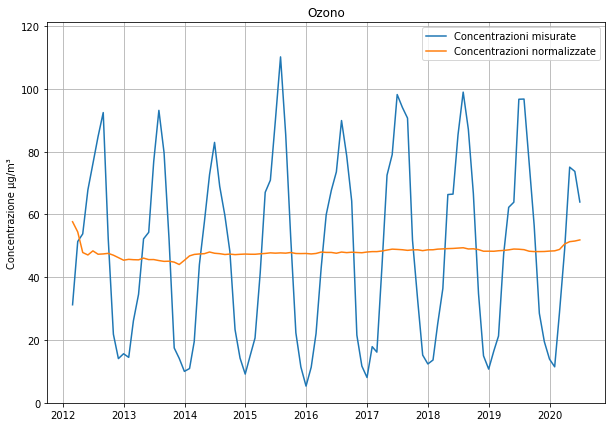

In [19]:
medie = get_mean_inquinante("O3")
medie_norm = get_mean_inquinante_normalizzato("O3")
medie = medie.groupby(pd.Grouper(freq="M")).mean()
medie_norm = medie_norm.groupby(pd.Grouper(freq="M")).mean()
max_y = max(medie.inquinante) if max(medie.inquinante) >= max(medie_norm.inquinante) else max(medie_norm.inquinante)
plt.plot(medie.index, medie.inquinante, label="Concentrazioni misurate")
plt.plot(medie_norm.index, medie_norm.inquinante, label="Concentrazioni normalizzate")
plt.ylabel("Concentrazione µg/m³")
plt.title("Ozono")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y/10))
plt.show()

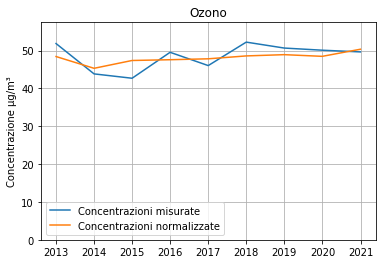

In [5]:
medie = get_mean_inquinante("O3")
medie_norm = get_mean_inquinante_normalizzato("O3")
medie = medie.groupby(pd.Grouper(freq="y")).mean()
medie_norm = medie_norm.groupby(pd.Grouper(freq="y")).mean()
max_y = max(medie.inquinante) if max(medie.inquinante) >= max(medie_norm.inquinante) else max(medie_norm.inquinante)
plt.plot(medie.index, medie.inquinante, label="Concentrazioni misurate")
plt.plot(medie_norm.index, medie_norm.inquinante, label="Concentrazioni normalizzate")
plt.ylabel("Concentrazione µg/m³")
plt.title("Ozono")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y/10))
plt.show()

L'andamento delle concentrazioni a partire dal 2013 è leggermente in aumento, anche se si mantiene su un livello piuttosto costante. Sicuramente questo è un inquinante su cui è difficile intervenire, per via delle sue origini complesse, perciò in futuro andrà mantenuto monitorato il suo andamento per verificarne l'evoluzione. 

Un aspetto da notare è che l'ozono, tra tutti gli inquinanti, è quello che la nostra tecnica riesce a trattare con la maggiore precisione ed infatti i modelli ottenuti usati per ricavare le serie normalizzate sono quelli che in fase di costruzione hanno mostrato le performance migliori. Questo probabilmente è collegato alla forte relazione che questo inquinante ha con la temperatura e, soprattutto, la radiazione solare, che i nostri modelli hanno ben individuato (come si è visto con l'importanza delle variabili) e che quindi gli permetteva di essere più precisi nell'attività predittoria.

## Ammoniaca ##
L'ammoniaca è un inquinante prodotto da processi degradativi di sostanza organica, le cui principali sorgenti sono infatti attività agricole e, in misura minore, il traporto su strada, lo smaltimento dei rifiuti e la combustione di legna e combustibili fossili. È un gas molto solubile in acqua, alla quale conferisce basicità e, tramite l'azione di particolari batteri, può favorire l'acidificazione del suolo. Inoltre l'interesse per l'ammoniaca è sempre crescente a causa della sua partecipazione nella formazione di particolato secondario quando presente in atmosfera.

Secondo INEMAR 2017 in Lombardia il 96% delle emissioni di questa sostanza sono collegabili al settore dell'agricoltura, che infatti è il principale responsabile per quanto riguarda questo inquinante. Il traffico, invece, arriva a dare un contributo pari solamente al 1% del totale annuo.

La normativa attuale non impone limiti per le concentrazioni registrate, anche se una serie di direttive europee per lo sviluppo rurale ha mirato, nel corso degli anni, a favorire la diffusione di buone pratiche per contenerne le emissioni, come ad esempio il divieto dello spargimento di liquami. 

Procediamo ora con l'analisi dei risultati ottenuti tramite i nostri modelli.

In [27]:
importances["Ammoniaca"].sort_values(ascending=False)

cols
epoch                   0.352432
day_of_year             0.146152
temperatura             0.116813
umidita                 0.089723
radiazione              0.073356
direzione_vento         0.066441
velocita_vento          0.056647
giorni_senza_pioggia    0.048331
day_of_week             0.026682
precipitazioni          0.023423
Name: Ammoniaca, dtype: float64

La variabile più importante risulta essere la data, seguita dal giorno dell'anno e dalla temperatura, con la prima a cui viene attribuita un'importanza decisamente maggiore rispetto a tutte le altre. Questo di solito avviene in due possibili scenari: o l'andamento presenta un trend e quindi la data serve proprio per identificarlo al meglio oppure è abbastanza casuale e la data diventa il modo migliore per capirne l'evoluzione.

Andiamo quindi a generare i grafici delle serie, per verificare se ci troviamo in uno dei due casi citati sopra.

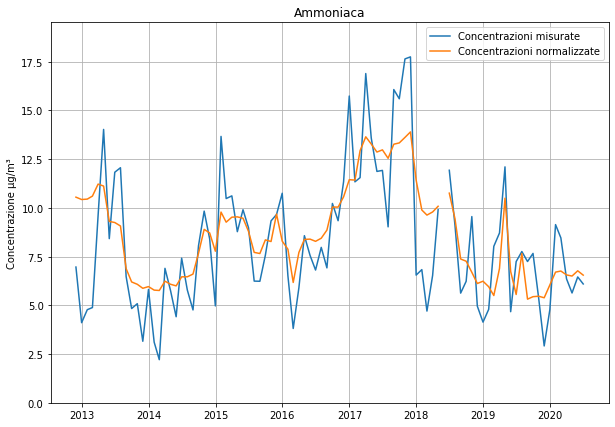

In [20]:
medie = get_mean_inquinante("Ammoniaca")
medie_norm = get_mean_inquinante_normalizzato("Ammoniaca")
medie = medie.groupby(pd.Grouper(freq="M")).mean()
medie_norm = medie_norm.groupby(pd.Grouper(freq="M")).mean()
max_y = max(medie.inquinante) if max(medie.inquinante) >= max(medie_norm.inquinante) else max(medie_norm.inquinante)
plt.plot(medie.index, medie.inquinante, label="Concentrazioni misurate")
plt.plot(medie_norm.index, medie_norm.inquinante, label="Concentrazioni normalizzate")
plt.ylabel("Concentrazione µg/m³")
plt.title("Ammoniaca")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y/10))
plt.show()

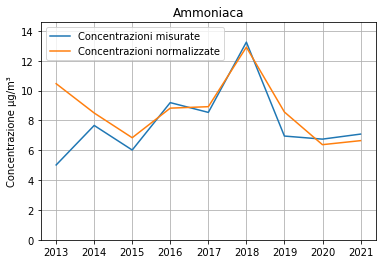

In [6]:
medie = get_mean_inquinante("Ammoniaca")
medie_norm = get_mean_inquinante_normalizzato("Ammoniaca")
medie = medie.groupby(pd.Grouper(freq="y")).mean()
medie_norm = medie_norm.groupby(pd.Grouper(freq="y")).mean()
max_y = max(medie.inquinante) if max(medie.inquinante) >= max(medie_norm.inquinante) else max(medie_norm.inquinante)
plt.plot(medie.index, medie.inquinante, label="Concentrazioni misurate")
plt.plot(medie_norm.index, medie_norm.inquinante, label="Concentrazioni normalizzate")
plt.ylabel("Concentrazione µg/m³")
plt.title("Ammoniaca")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y/10))
plt.show()

Vediamo come nel corso degli ultimi anni le concentrazioni si siano tenute su un livello abbastanza costante, con qualche piccolo aumento e diminuzione poco significativi. Direi che quindi ci troviamo nello scenario in cui il nostro modello usa la data poichè è la migliore informazione che riesce ad avere per stimare l'andamento abbastanza casuale, ma che si mantiene costante intorno ad un valore medio, delle concetrazioni di questo inquinante.

## Benzene ##
Il benzene viene sintetizzato dal petrolio e viene usato per produrre materie plastiche, resine sintetiche e pesticidi, come solvente e come sostanza antidetonante nella benzina. Il benzene, infatti, ad inizio anni 90 ha sostituito il piombo come additivo presente nella benzina, permettendo il passaggio da quella rossa a quella verde.  
Quello presente in atmosfera deriva da processi di combustione incompleta di combustibili fossili, quindi da attività come traffico (soprattutto dai veicoli a benzina) e processi di combustione industriale. 

La sua pericolosità per la salute umana varia molto a seconda della concentrazione e della durata dell'esposizione, ma anche alle basse quantità a cui viene misurato in atmosfera può comunque essere pericoloso: lo IARC (agenzia internazionale per la ricerca sul cancro) l'ha infatti inserito tra le sostanze per le quali esiste una sufficiente evidenza di cancerogenicità per l'uomo.

Il D.Lgs 155/2010 stabilisce per questo inquinante un valore limite di 5µg/m³ per la media oraria, che viene ampiamente rispettato in tutta la regione. 

Passiamo ora all'analisi dei risultati ottenuti dai nostri modelli.

In [28]:
importances["Benzene"].sort_values(ascending=False)

cols
temperatura             0.269504
day_of_year             0.168472
epoch                   0.162360
velocita_vento          0.153684
radiazione              0.076012
umidita                 0.068633
direzione_vento         0.039195
giorni_senza_pioggia    0.024561
day_of_week             0.018799
precipitazioni          0.018780
Name: Benzene, dtype: float64

Anche per questo inquinnte l'importanza delle variabili è abbastanza in linea con quanto già ottenuto in precedenza per altri inquinanti.

Verifichiamo l'andamento delle serie storiche tramite la generazione di grafici.

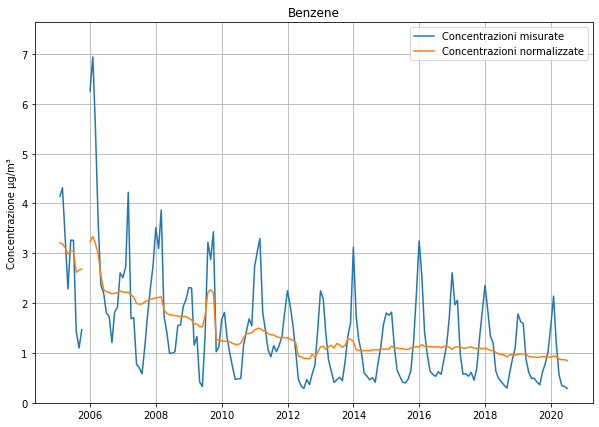

In [21]:
medie = get_mean_inquinante("Benzene")
medie_norm = get_mean_inquinante_normalizzato("Benzene")
medie = medie.groupby(pd.Grouper(freq="M")).mean()
medie_norm = medie_norm.groupby(pd.Grouper(freq="M")).mean()
max_y = max(medie.inquinante) if max(medie.inquinante) >= max(medie_norm.inquinante) else max(medie_norm.inquinante)
plt.plot(medie.index, medie.inquinante, label="Concentrazioni misurate")
plt.plot(medie_norm.index, medie_norm.inquinante, label="Concentrazioni normalizzate")
plt.ylabel("Concentrazione µg/m³")
plt.title("Benzene")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y/10))
plt.show()

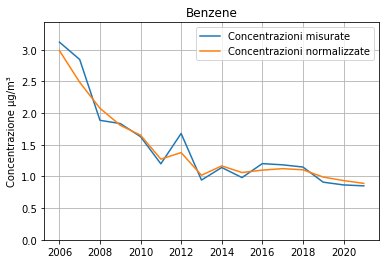

In [7]:
medie = get_mean_inquinante("Benzene")
medie_norm = get_mean_inquinante_normalizzato("Benzene")
medie = medie.groupby(pd.Grouper(freq="y")).mean()
medie_norm = medie_norm.groupby(pd.Grouper(freq="y")).mean()
max_y = max(medie.inquinante) if max(medie.inquinante) >= max(medie_norm.inquinante) else max(medie_norm.inquinante)
plt.plot(medie.index, medie.inquinante, label="Concentrazioni misurate")
plt.plot(medie_norm.index, medie_norm.inquinante, label="Concentrazioni normalizzate")
plt.ylabel("Concentrazione µg/m³")
plt.title("Benzene")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y/10))
plt.show()

Per il benzene i maggiori cali si sono registrati a partire dai primi anni 2000, ed infatti nella parte iniziale del grafico si può notare maggiormente questa tendenza, che negli anni più recenti è andata a smorzarsi, probabilmente per l'avvicinamento a un valore limite oltre il quale sarà più difficile scendere ulteriormente.

## SO2 ##
Sebbene una volta fosse sicuramente uno degli inquinanti a destare più proccupazioni, così come è stato uno dei primi ad essere monitorato e limitato per legge, è già ormai diversi anni che le concentrazioni di biossido di zolfo sono ampiamente sotto al limite legislativo per questo inquinante (350 µg/m³ media oraria), visto che a partire dagli anni 90 sono state introdotte una serie di normative atte a limitarne le emissioni. Le più importanti sono sicuramente quelle riguardanti gli usi di gasolio e nafta come forme di riscaldamento, che ormai sono stati completamente sostituiti dal metano, e quelle che nel corso degli anni hanno progressivamente abbassato il limite di zolfo che può essere contenuto nei carburanti (da 0.8% nel 1980 a 0.2% nel 1995 e infine a 0.1% nel 2008).  

Sebbene non vi siano più preoccupazioni per quanto riguarda le concentrazioni di questa sostanza in atmosfera ritengo che sia utile verificare anche con essa i risultati ottenuti tramite la nostra tecnica. Proviamo quindi a controllare l'importanza delle variabili dei modelli ottenuti per verificare cosa abbiamo ottenuto.

In [29]:
importances["SO2"].sort_values(ascending=False)

cols
epoch                   0.416001
day_of_year             0.143045
temperatura             0.112839
velocita_vento          0.065865
radiazione              0.060573
umidita                 0.056521
direzione_vento         0.050973
giorni_senza_pioggia    0.050533
precipitazioni          0.024355
day_of_week             0.019295
Name: SO2, dtype: float64

La data risulta di gran lunga la variabile più importante, con giorno dell'anno e temperatura che sono le sole due variabili a cui viene data un minimo di importanza. Ancora una volta il fatto che la data sia così importante ci fa capire come il nostro modello riesca ad identificare al meglio l'andamento casuale delle concentrazioni usando questa informazione.

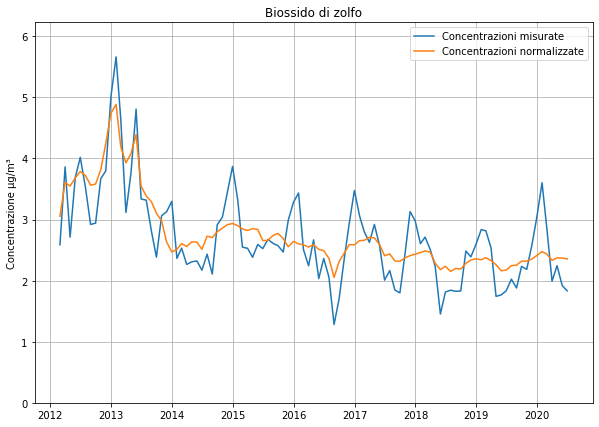

In [22]:
medie = get_mean_inquinante("SO2")
medie_norm = get_mean_inquinante_normalizzato("SO2")
medie = medie.groupby(pd.Grouper(freq="M")).mean()
medie_norm = medie_norm.groupby(pd.Grouper(freq="M")).mean()
max_y = max(medie.inquinante) if max(medie.inquinante) >= max(medie_norm.inquinante) else max(medie_norm.inquinante)
plt.plot(medie.index, medie.inquinante, label="Concentrazioni misurate")
plt.plot(medie_norm.index, medie_norm.inquinante, label="Concentrazioni normalizzate")
plt.ylabel("Concentrazione µg/m³")
plt.title("Biossido di zolfo")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y/10))
plt.show()

In [ ]:
medie = get_mean_inquinante("SO2")
medie_norm = get_mean_inquinante_normalizzato("SO2")
medie = medie.groupby(pd.Grouper(freq="y")).mean()
medie_norm = medie_norm.groupby(pd.Grouper(freq="y")).mean()
max_y = max(medie.inquinante) if max(medie.inquinante) >= max(medie_norm.inquinante) else max(medie_norm.inquinante)
plt.plot(medie.index, medie.inquinante, label="Concentrazioni misurate")
plt.plot(medie_norm.index, medie_norm.inquinante, label="Concentrazioni normalizzate")
plt.ylabel("Concentrazione µg/m³")
plt.title("Biossido di zolfo")
plt.legend()
plt.grid()
plt.ylim(0, max_y + (max_y/10))
plt.show()

Come si può vedere le concentrazioni di SO2 registrate sono ormai a livelli bassissimi, tanto da non destare più preoccupazioni. L'andamento nel corso degli ultimi anni è abbastanza costante, fatto salvo per la classica variabilità stagionale, come si vede sia dalla serie normalizzata che già guardando i dati grezzi, e credo che anche i risultati ottenuti diano sostegno all'ipotesi di aver individuato il fondo naturale (confermato anche da ARPA, sempre nel rapporto sulla qualità dell'aria milanese).  